In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
import pygmt

import pooch
import boule as bl
import verde as vd
import harmonica as hm

## Download data

In [2]:
# Download and cache the CSV version (no metadata)
fname = pooch.retrieve(
    url="doi:10.6084/m9.figshare.13643837/australia-ground-gravity.csv",
    known_hash="md5:d47fef200d92c682dc8b63fe31b80364",
    progressbar=True,
)

# Load the data with pandas
data = pd.read_csv(fname)
data

,gravity,gravity_accuracy,height_error,reliability_index,survey_id,longitude,latitude,height
0,979314.81,0.2,10.06,1,195951,138.620497,-31.117129,515.11
1,979322.00,0.2,10.06,1,195951,138.612697,-31.128329,470.83
2,979303.88,0.2,10.06,1,195951,138.755195,-31.094027,541.83
3,979306.88,0.2,10.06,1,195951,138.764895,-31.088427,526.33
4,979320.62,0.2,10.06,1,195951,138.825194,-31.086327,462.98
...,...,...,...,...,...,...,...,...
1789360,978682.50,0.2,6.16,4,196111,133.229599,-24.218554,602.45
1789361,978698.88,0.2,6.16,4,196111,135.242914,-23.478536,457.36
1789362,978721.31,0.2,6.16,4,196111,132.416280,-24.560232,565.01
1789363,978956.88,0.2,6.16,4,196111,139.114555,-25.496838,103.87


In [3]:
region = (128, 136, -26, -20)

coordinates = (data.longitude, data.latitude)
inside = vd.inside(coordinates, region)

data = data[inside]
data

,gravity,gravity_accuracy,height_error,reliability_index,survey_id,longitude,latitude,height
11000,978632.00,0.01,5.06,1,196600,135.237899,-21.750203,424.24
11008,978834.62,0.60,1.06,1,199681,129.690032,-25.649330,687.99
11009,978831.62,0.60,1.06,1,199681,129.705192,-25.638730,690.41
11010,978828.19,0.60,1.06,1,199681,129.727941,-25.624080,695.85
11011,978827.00,0.60,1.06,1,199681,129.747611,-25.619539,700.10
...,...,...,...,...,...,...,...,...
1789351,978848.12,0.20,6.16,4,196111,134.827933,-25.023543,352.75
1789358,978630.62,0.20,6.16,4,196111,131.917941,-23.280232,640.69
1789360,978682.50,0.20,6.16,4,196111,133.229599,-24.218554,602.45
1789361,978698.88,0.20,6.16,4,196111,135.242914,-23.478536,457.36


In [4]:
reducer = vd.BlockReduce(
    np.median, spacing=5 / 60, region=region, drop_coords=False
)

In [5]:
coords, gravity = reducer.filter((data.longitude, data.latitude, data.height), data.gravity)

In [6]:
coords[0].size

6587

In [7]:
df = pd.DataFrame(
    {"longitude": coords[0], "latitude": coords[1], "height": coords[2], "gravity": gravity}
)

In [8]:
df

,longitude,latitude,height,gravity
0,128.044657,-25.967222,506.670,978883.620
1,128.126386,-25.973100,520.380,978873.000
2,128.206151,-25.975900,527.905,978872.285
3,128.300509,-25.969732,545.220,978872.120
4,128.375399,-25.969807,559.490,978871.120
...,...,...,...,...
6582,135.630200,-20.038805,291.000,978559.155
6583,135.710150,-20.037895,284.040,978562.595
6584,135.784400,-20.039506,281.255,978559.810
6585,135.878800,-20.037605,273.400,978552.690


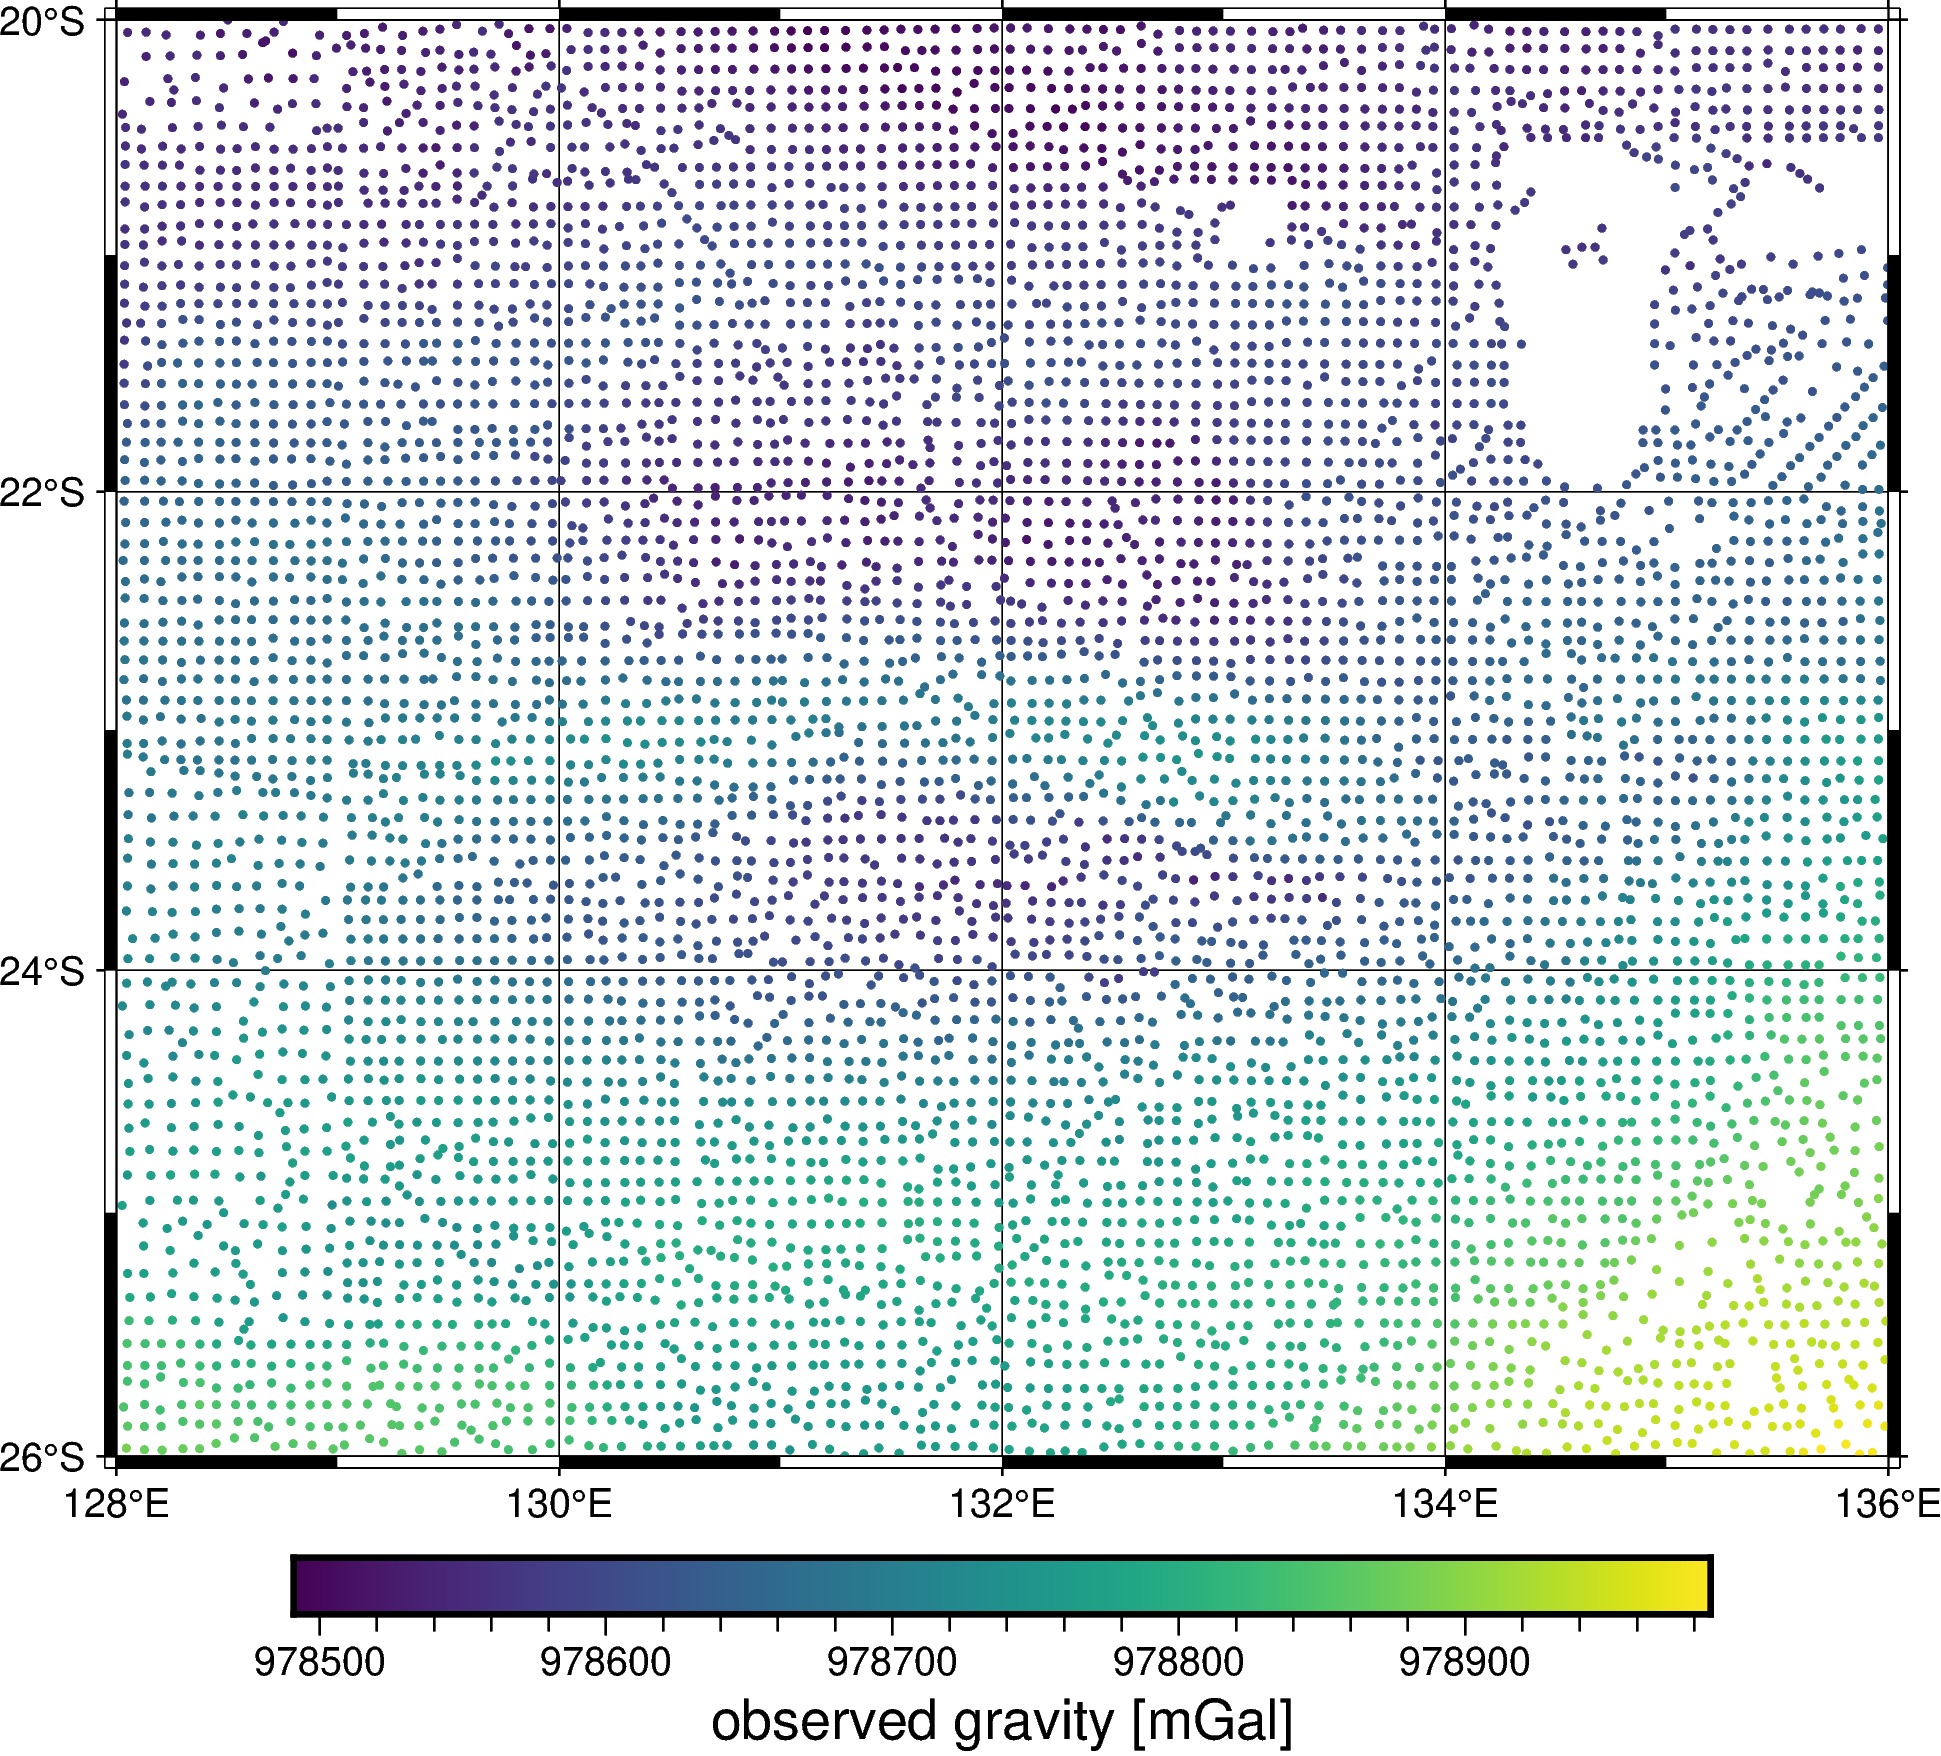

In [9]:
fig = pygmt.Figure()
pygmt.makecpt(
    cmap="viridis",
    series=[df.gravity.min(), df.gravity.max()]
)
fig.plot(
    x=df.longitude,
    y=df.latitude,
    color=df.gravity,
    cmap=True, 
    style="c2p",  # circles with 4px as diameter
    projection="M15c",  # mercator projection with 15cm of width
    frame="afg"
)
fig.coast(shorelines="black", area_thresh=1e6)
fig.colorbar(frame='af+l"observed gravity [mGal]')
fig.show()

In [10]:
df.to_csv("australia_gravity.csv", index=False)